在我们使用RNN的时候，输入数据的初始化权重矩阵和隐状态下的权重矩阵都是共享的。对于DRNN也是如此，每层的隐状态权重矩阵都是一样的，这样也是为了减少计算量。

simpleRNN也时常被称为Naive RNN，在LSTM中的输入不再只有当前输入和隐状态输入，还包括内存记忆，这部分信息的初始化权重矩阵要求是对称矩阵。

$$z = tanh(W \cdot [x^t, h^{t-1}, c^{t-1}]^T)$$
$$c^t = z^f \odot c^{t-1} + z^i \odot z$$
$$h^t = z^o \odot tanh(c^t)$$
$$y^t = \sigma(W'h^t)$$
$$z^f = \sigma(W^f \cdot [x^t, h^{t-1}]^T)$$
$$z^i = \sigma(W^i \cdot [x^t, h^{t-1}]^T)$$
$$z^o = \sigma(W^o \cdot [x^t, h^{t-1}]^T)$$

注：$z$也时常被称为候选状态$(c^t)’$

GRU只有两个门，一个重置门和一个更新门

$$r = \sigma(W^r \cdot [x^t, h^{t-1}]^T)$$
$$z = \sigma(W^z \cdot [x^t, h^{t-1}]^T)$$
$$h' = r \odot tanh(h^{t-1})$$
$$h^t = z \odot h^{t-1} + (1-z) \odot h'$$
$$y^t = \sigma(W'h^t)$$

在对于LSTM的门控个数选择上也有过相关的讨论，最终结果是LSTM和GRU有相当的性能，其它没有输入，输出，最不能没有遗忘门的功能。

另外，还有其它的扩展：

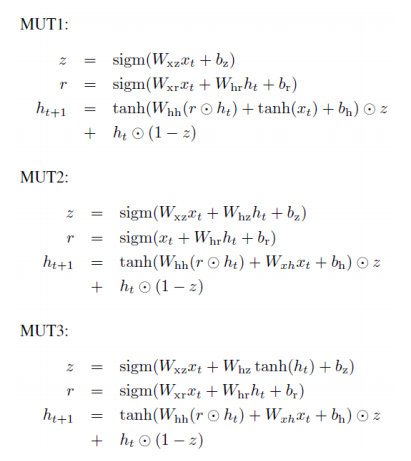

还有一个扩展思路就是结合使用强化学习，来决定这个几个门控之间的操作运算，是选择add，elem_mult，tanh，sigmoid，relu，还是什么，这个倒是一个很有意思的想法。

序列生成，如生成单词，句子等，成语接龙就是一个例子。序列生成最主要的是要标记开始\"<BOS\>和结束\"<SOS\>，比如来生成一段小说，知道输出\"<SOS\>即为段落结束。

这里我们来细致剖析下RNN，或者LSTM... 比如我们这边有一篇文档，我们将其词袋化，然后统计每个词的个数，包含一些特殊符号和句点符号，然后按照从大到小的顺序排列，这时我们就可以得到每个词对应的index，这边就有了词与Index的对应关系，这主要是为了方便我们将序列转换为整数index，也能够在后续预测时，能够将得到的整数index转换成词。有了词袋后，整个词袋的大小也就知道了，这个词袋的大小是为了前期将每个词用one-hot编码进行表示的，后续RNN的输出分布也是这个词袋的大小，只不过我们选择最大概率的那个index输出而已。再来我们需要找到序列中最大的长度，这个长度就是我们序列输入的个数，因为每个序列是不等长的，一种方法是使用前后补0法，使其等长，另一种方法，就是将这篇文档组合成一个大的序列，然后再等分序列，这种方法不是很好，我们还是使用补0法。然后，就要说到词嵌入，这个主要是为了将之前使用one-hot编码的高维稀疏向量转换成低维稠密向量的，也是为了能够表达词与词之间的相关性。所以说我们的输入，一般是一个三维张量(batch_size, maxlen, vocab_size)，输出为(batch_size, maxlen, embedding_size)，这边我们需要关注的maxlen，它是每层序列的个数，这个个数决定了我们RNN序列的长度，而在选择RNN或LSTM的units，这个参数其实是在建立深度的RNN，也就是多层的RNN。

这种序列生成的例子，不但可以生成文本，还可以生成图像，但是生成图像一个问题，相邻的像素是相关的，我们不但要根据前面的预测作为下次输入，还需要与其相邻的像素作为输入，这就是我们的PixelRNN，如下图所示：

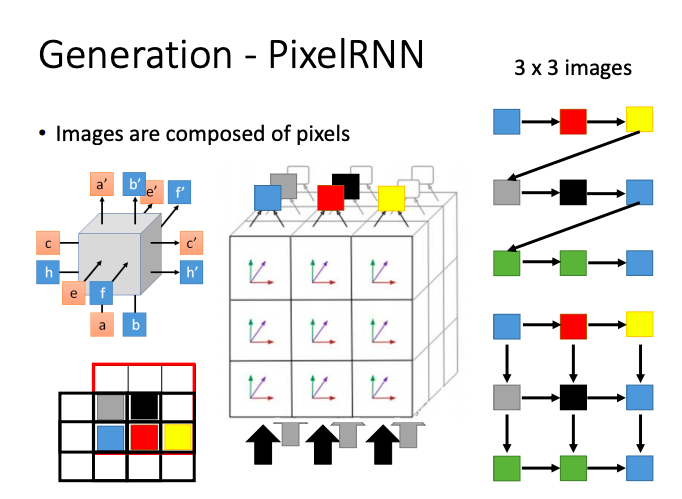

一般说的序列生成，也不是随机生成，是有条件的，是希望得到期望的输出。比如让其看一副图片，然后识别其内容，亦或是聊天机器人，机器翻译等...

在机器翻译中，一般我们会使用注意力机制，给定一个初始查询向量$q^0$，这个向量会会与序列的每个输出的隐状态去匹配，当生成新的查询向量时，也会如此，这是在测试阶段，主要是为了能够保证序列的每个预测输出的相关性与准确性。

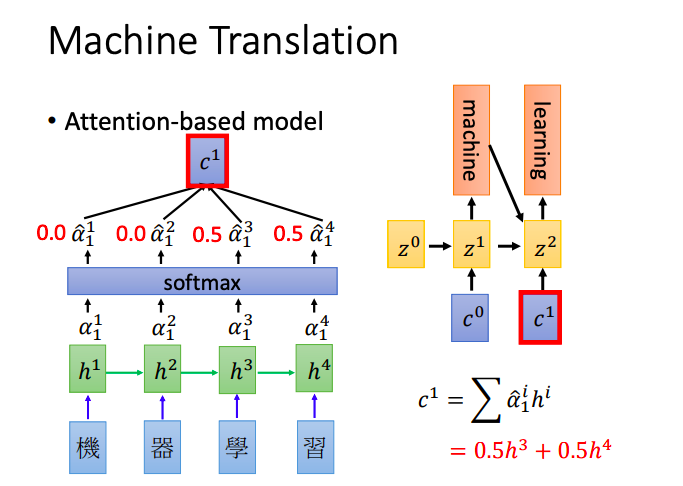

还有根据句子中的关键词来聚焦图像中的对象，如下图：

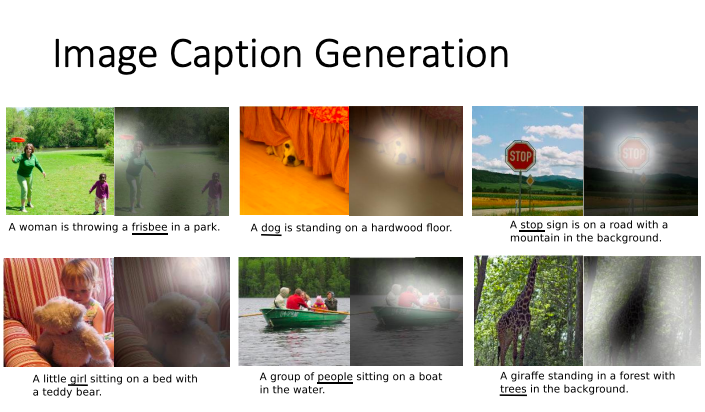

视频描述：

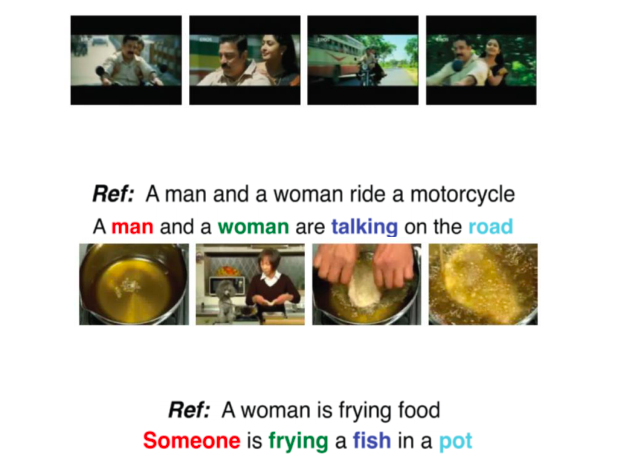

在使用注意力机制的时候，应该注意，每个输入序列应该给予相同的注意权重参数。也就说在得到原始的每个注意力值输出时，我们需要定义一个固定值，使得每次生成的注意力权重应尽量保持一致。

生成序列的一些Tips：

生成序列中有一个mismatch的问题，就是在训练时使用的是真实label，作为交叉损失来训练的，而测试时使用的确是预测的值作为下一个输入，这个会存在mismatch的问题。但如果在训练阶段使用预测值的话，就会出现一步错步步错的情况，在测试时固然错的更离谱。为了使得训练的模型能够适用于测试，我们不能直接使用真实值，也不能都使用预测值，这该怎么办呢？有个办法就是通过掷硬币的方式每次在真实值和训练值之间做选择，这样能够减小误差率。

另一种方法就是使用beam search的方法，根据要求设定beam size的大小，也就是每次的决策分支大小，从树根开始，保留路径中分数最高的几个，即为最有可能的使用值。这种方法其实是使用预测值的方法，但是是在这个树空间中搜索最佳路径相对应的值。

还有一种方法就是采用强化学习去做，action就是最后的输出，observation就是前期的预测输出值，每次的take action会影响下一步得到的观测数据。

Pointer Network（为方便起见以下称为指针网络）是seq2seq模型的一个变种。他们不是把一个序列转换成另一个序列, 而是产生一系列指向输入序列元素的指针。最基础的用法是对可变长度序列或集合的元素进行排序。

比如这样一个应用，我们在机器翻译中，原始句子中出现的某些词是不需要翻译的，就需要这个部分还延续到下面，这个时候就可以使用指针网络。还有我们可以对文本做总结！！